In [1]:
!pip install gradio

     |████████████████████████████████| 1.1MB 19.0MB/s 
     |████████████████████████████████| 215kB 49.7MB/s 
     |████████████████████████████████| 1.9MB 43.6MB/s 
     |████████████████████████████████| 3.2MB 50.1MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 962kB 51.3MB/s 
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=5620938c9dc43bab66553cea83ca39693fbabd3f5d82cd898df74da4580d69b6
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=f68c9227c59a5df4bb9271bed06b05c2967fa51b249493109a098cedf080fd77
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
Successfully built flask-cachebuster ffmpy


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.vgg16 import VGG16

import matplotlib.pylab as plt
import numpy as np
import gradio as gr

In [3]:
datasets, info = tfds.load(name="rock_paper_scissors", with_info = True, as_supervised=True, split=['train','test'])

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteAIOB5E/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteAIOB5E/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


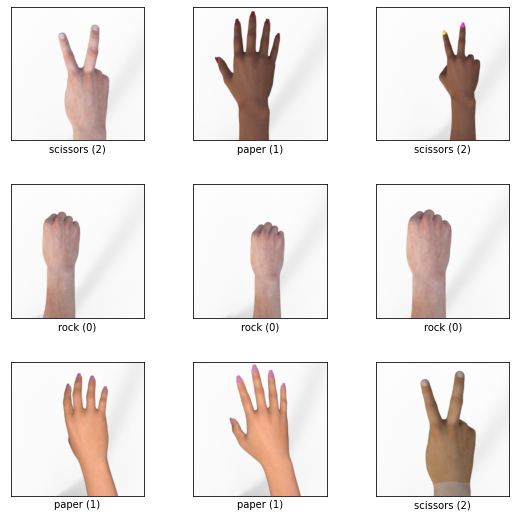

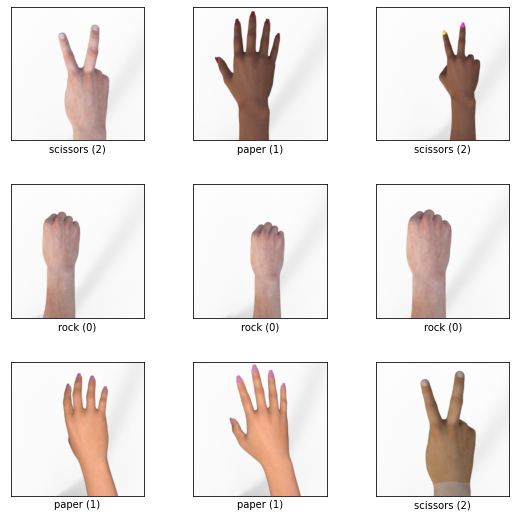

In [4]:
train, info_train = tfds.load(name='rock_paper_scissors', with_info=True, split='test')
tfds.show_examples(info_train, train)

In [5]:
def img_scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [6]:
def get_dataset(BATCH_SIZE=128):
  train_dataset_scaled = datasets[0].map(img_scale).shuffle(1000).batch(BATCH_SIZE)
  test_dataset_scaled =  datasets[1].map(img_scale).batch(BATCH_SIZE)
  return train_dataset_scaled, test_dataset_scaled

In [7]:
train_dataset, test_dataset = get_dataset()

In [8]:
vgg = VGG16(input_shape = [224,224,3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [9]:
for layer in vgg.layers:
  layer.trainable = False

In [10]:
c = Flatten()(vgg.output)
prediction = Dense(3, activation="softmax")(c)
model = Model(inputs=vgg.input,outputs=prediction)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [13]:
history = model.fit(train_dataset, epochs=3)

Epoch 1/3
20/20 [==============================] - 77s 1s/step - loss: 1.0772 - acc: 0.6272
Epoch 2/3
20/20 [==============================] - 16s 666ms/step - loss: 0.0261 - acc: 0.9941
Epoch 3/3
20/20 [==============================] - 16s 658ms/step - loss: 0.0075 - acc: 1.0000


In [14]:
loss, acc = model.evaluate(test_dataset)

3/3 [==============================] - 21s 10s/step - loss: 0.2229 - acc: 0.9113


In [15]:
model.save('rock_paper_scissors_gr.h5')

In [16]:
def classifier(image):
  img = tf.image.resize(image,[224,224])
  img = np.expand_dims(img, axis=0)                
  pred = model.predict(img)
  pred_label = info.features["label"].names[np.argmax(pred)]                          
  return pred_label

iface = gr.Interface(classifier, gr.inputs.Image(shape=(224, 224)), gr.outputs.Label(num_top_classes=3))
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://19792.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://19792.gradio.app')